# Neural Network application

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

plt.rcParams['text.usetex'] = True
result_path = "../results/"

Load and prepare data:

In [2]:
path = "../data/"
file_pre = "prep_data.csv"
file_data = "CTG.xls"

fetus_pre = pd.read_csv(path+file_pre)
fetus_pre = fetus_pre.reindex(np.random.permutation(fetus_pre.index))
fetus = pd.read_excel(path+file_data, sheet_name = "Data",header=1)
fetus = fetus.reindex(np.random.permutation(fetus.index))
# Columns to be considered in the dataset
columns = ["LB", "AC", "FM", "UC", "DL", "DP", 
           "ASTV", "MSTV", "ALTV", "MLTV", "Width", "Min", 
           "Max", "Nmax", "Nzeros", "Mode", "Mean", "Median", "Variance", "Tendency"]
# Prepocessed dataset
X = fetus_pre[columns]
y = fetus_pre["NSP"]

# Raw dataset
X_raw = fetus[columns]
y_raw = fetus["NSP"]

# One-hot enconding of target values
y_cat = utils.to_categorical(y-1)
y_cat_raw = utils.to_categorical(y_raw-1)

# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, random_state = 45, train_size = 0.8)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_cat_raw, random_state = 45, train_size = 0.8)


In [3]:
def evaluate(y_pred, y_test, model):
    
    # Apply argmax
    y_pred = np.argmax(y_pred,axis=1)
    y_compare = np.argmax(y_test,axis=1)
    
    print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
    print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))
    
    if model:
    
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (5,5))
    
        ax1 = plt.plot(model.history['loss'])
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        
        ax2 = plt.plot(model.history['accuracy'])
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")

    cm = confusion_matrix(y_compare, y_pred, normalize="all")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
    disp.plot()
    


# PCA

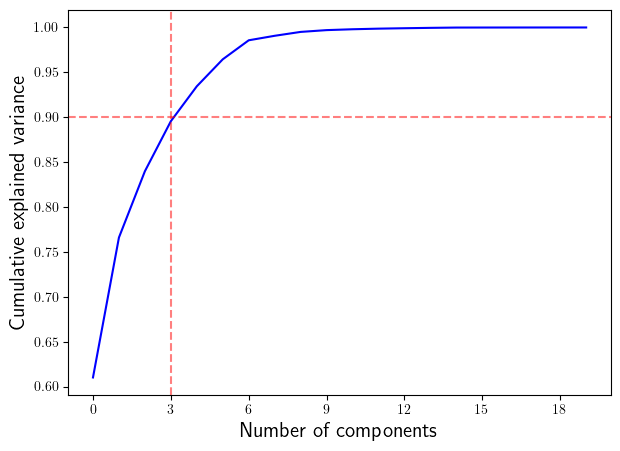

In [105]:
import matplotlib.pyplot as plt

#Apply PCA to raw data
pca = PCA()
pca.fit(X)

fig, ax = plt.subplots(figsize=(7,5))

plt.plot(np.cumsum(pca.explained_variance_ratio_),c="b")
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');
ax.axhline(0.90, c = "red", linestyle="--", alpha = 0.5)
ax.axvline(3, c = "red", linestyle="--", alpha = 0.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

plt.savefig(result_path+"/CEV") 

Applying PCA to both raw and scaled data, the cumulative explained variance displays different trends. A 90% variance is obtained with 3 components for the raw data and for 10 components for the scaled data. 

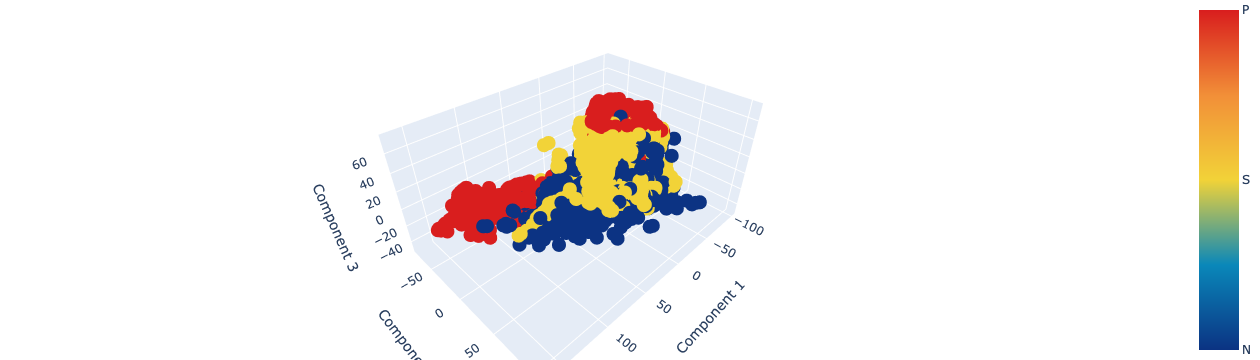

In [92]:
pca = PCA(3) 
X3 = pca.fit_transform(X)

# Draw results fro PCA
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d( x=X3[:,0], y=X3[:,1], z=X3[:,2], 
                                   mode='markers', 
                                   marker=dict( color = y, 
                                                colorscale = 'portland', 
                                                colorbar=dict( thickness = 40, 
                                                               tickvals=[1, 2, 3],
                                                               ticktext=['N', 'S', 'P'])))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene = dict(xaxis_title="Component 1",yaxis_title="Component 2",zaxis_title="Component 3"))


fig.show()

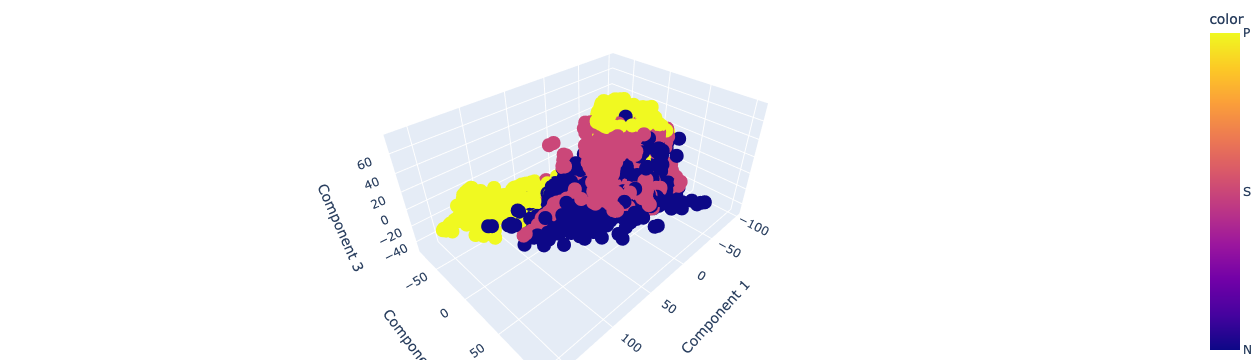

In [46]:

import plotly.express as px

X_plot = pd.DataFrame(X3,columns=["Component 1","Component 2","Component 3"])
fig = px.scatter_3d(X_plot, x="Component 1", y = "Component 2", z = "Component 3", color=y, color_discrete_map=2)
#fig = go.Scatter3d(X_plot, x="Component 1", y = "Component 2", z = "Component 3", marker=dict(color=y, colorscale='Viridis'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))



In [14]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y_cat, random_state = 45, train_size = 0.8)

# Change activation function

## HL(15, sigmoid)

In [12]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                60        
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


2022-12-05 15:09:05.827915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


31/31 [==============================] - 0s 945us/step


Accuracy: 0.83
Recall: 0.84


AttributeError: 'list' object has no attribute 'set_xlabel'

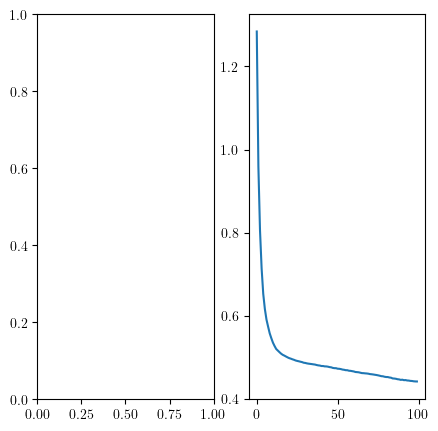

In [13]:
evaluate(y3_pred, y3_test,model_trace)

## HL(15, relu)

In [ ]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
print("Prediction time: %.3f s"%pred_time)
evaluate(y3_pred, y3_test, None)

# Change nodes in the first layer

In this section, we focus on trying to understand the pros and cons on using PCA in this particular case.

## HL(30, sigmoid)

Parameters difference:

- 3 feat: 213 params
- 20 feat: 723 params

In [ ]:
model = Sequential()
model.add(Dense(30, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

model.fit(X3_train,y3_train,verbose=0,epochs=200)

y3_pred = model.predict(X3_test)

evaluate(y3_pred, y3_test)

## HL(60, sigmoid)

Parameters difference:

- 3 feat: 423 params
- 20 feat: 1443 params

In [ ]:
model = Sequential()
model.add(Dense(60, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

model.fit(X3_train,y3_train,verbose=1,epochs=100)

y3_pred = model.predict(X3_test)

evaluate(y3_pred, y3_test)

# Two or more layers

## HL(15, relu), HL(15, relu)

In [ ]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
print("Prediction time: %.3f s"%pred_time)
evaluate(y3_pred,y_test,None)

In [ ]:
evaluate(y3_pred,y_test,model_trace)

## HL(15, relu), HL(15, relu), HL(15, relu), HL(15, relu)

In [ ]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f"%fit_time)
print("Prediction time: %.3f"%pred_time)
evaluate(y3_pred,y_test,None)

## HL(30, relu), HL(15, relu)

In [ ]:
model = Sequential()
model.add(Dense(30, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
evaluate(y3_pred,y_test,None)

## HL(60, relu), HL(50, relu), HL(40, relu), HL(30, relu)

In [ ]:
model = Sequential()
model.add(Dense(60, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100)
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f"%fit_time)
print("Prediction time: %.3f"%pred_time)
evaluate(y3_pred,y_test,None)

## HL(100, relu), HL(100, relu), HL(100, relu), HL(100, relu) - BEST ONE

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               400       
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 3)                 303       
                                                                 
Total params: 31,003
Trainable params: 31,003
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 910us/

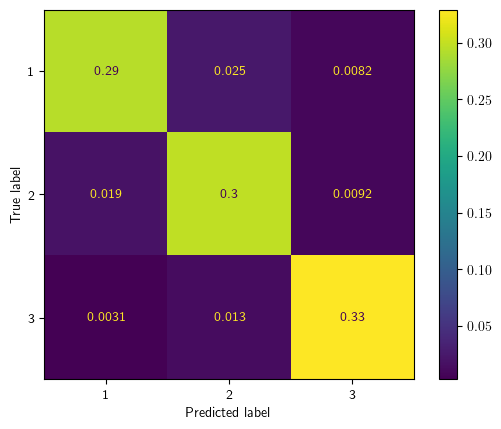

In [14]:
model = Sequential()
model.add(Dense(100, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=150)
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
evaluate(y3_pred,y_test,None)

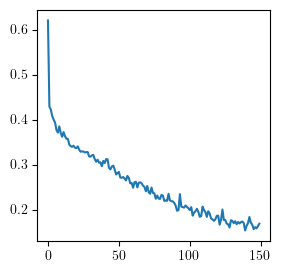

In [15]:
plt.figure(figsize=(3,3))
    
plt.plot(model_trace.history['loss'])

# Model evaluation

In [16]:
pca = PCA(3) 
X3_raw = pca.fit_transform(X_raw)

67/67 [==============================] - 0s 1ms/step
===RESULTS================================
Accuracy: 0.41
Recall: 0.37


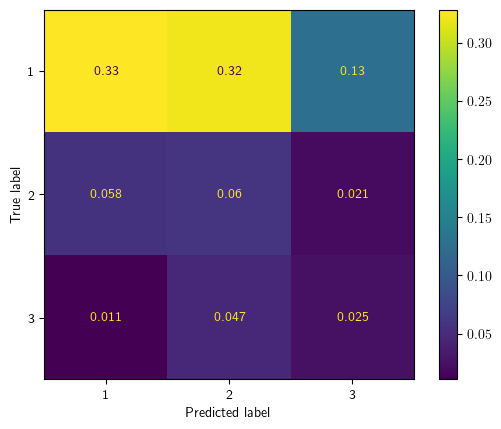

In [17]:
y3_pred = model.predict(X3_raw)

print("===RESULTS================================")
y_pred = np.argmax(y3_pred, axis=1)
y_compare = y_raw-1
    
print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))


cm = confusion_matrix(y_compare, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
disp.plot()
